In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import Dense, MaxPool2D, Conv2D, Flatten
from keras.models import Sequential
from tensorflow.keras.utils import img_to_array, load_img
import glob
import cv2
from IPython.display import Image
import tensorflow as tf
import joblib

# Data Exploration

In [2]:
train_path = 'dataset/train/'
test_path = 'dataset/test/'

In [3]:
boards = []
images = glob.glob(train_path + '*')

for image in images:
    boards.append(image.split('/')[2].split('.')[0])
    
print(boards[0])

1R2n3-1P6-8-3r4-1K3k2-r7-7b-8


In [4]:
im = cv2.imread(images[0])
print(im.shape)

(400, 400, 3)


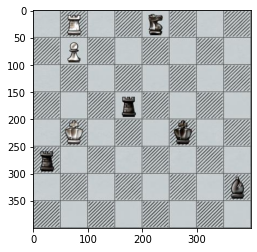

In [5]:
plt.imshow(im)

Since image size is 400x400, each tile should be 50x50 pixels. By moving the pixel range by 50 each loop for 8 loops (vertically and horizontally), we should get each tile seperately

In [6]:
tiles = []
for i in range(8):
    for j in range(8):
        cropped_im = im[0+50*i:50+50*i, 0+50*j:50+50*j]
        tiles.append(cropped_im)

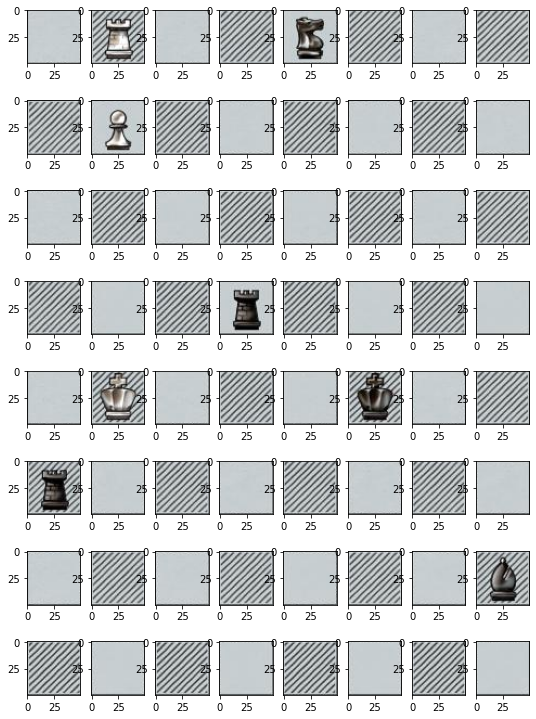

In [7]:
columns = 8
rows = 8
fig = plt.figure(figsize=(9, 13))
for i in range(1, 65):
    img = tiles[i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

Splitting the filename into labels

In [8]:
#Replace numbers with 'Empty' so they can be classified
board_rows = boards[0].split('-')
row = list(board_rows[0])
new_row = []

for char in row:
    if char.isnumeric():
        num = int(char)
        for i in range(num):
            new_row.append('Empty')
    else:
        new_row.append(char)
        
print(new_row)

['Empty', 'R', 'Empty', 'Empty', 'n', 'Empty', 'Empty', 'Empty']


In [9]:
print(row)

['1', 'R', '2', 'n', '3']


In [10]:
tiles_df = pd.DataFrame(columns=["tile", "label"])

### Create function to split given board into 64 tiles

In [11]:
def split_board(path):
    
    im_path = 'dataset/train/' + path
    board = im_path.split('/')[2].split('.')[0]
    im = cv2.imread(im_path)
    
    tiles = []
    for i in range(8):
        for j in range(8):
            cropped_im = im[0+50*i:50+50*i, 0+50*j:50+50*j]
            tiles.append(cropped_im)
            
            
    board_rows = board.split('-')
    
    tile_labels = list(board_rows[0]) + list(board_rows[1]) + 
    list(board_rows[2]) + list(board_rows[3]) + list(board_rows[4]) + 
    list(board_rows[5]) + list(board_rows[6]) + list(board_rows[7])
    
    new_tile_labels = []

    for char in tile_labels:
        if char.isnumeric():
            num = int(char)
            for i in range(num):
                new_tile_labels.append('Empty')
        else:
            new_tile_labels.append(char)
            
    for i in range(64):
        new_row = [tiles[i], new_tile_labels[i]]
        tiles_df.loc[len(tiles_df)] = new_row



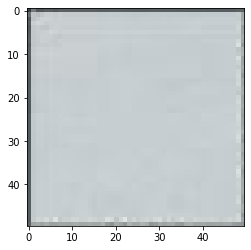

In [12]:
columns = 8
rows = 8

img = tiles[0]
plt.imshow(img)
plt.show()


In [13]:
tiles_df = pd.DataFrame(columns=["tile", "label"])
tiles_df.head()

,tile,label


Import 10,000 images from the train dataset to split into tiles and label each tile

In [14]:
images = glob.glob(train_path + '*')

for image in images[0:10000]:
    im_name = image.split('/')[2]
    split_board(im_name)
    
tiles_df.head()

1


1862


3501


5140


6779


8418


,tile,label
0,"[[[56, 61, 64], [115, 120, 123], [82, 87, 90],...",Empty
1,"[[[69, 74, 75], [82, 87, 88], [87, 92, 93], [8...",R
2,"[[[64, 69, 72], [92, 97, 100], [91, 96, 99], [...",Empty
3,"[[[60, 65, 68], [93, 98, 101], [83, 88, 91], [...",Empty
4,"[[[61, 66, 67], [110, 115, 116], [82, 87, 88],...",n


Check value counts for biases

In [15]:
tiles_df['label'].value_counts()

Empty    539610
K         10000
k         10000
P          9221
p          9043
R          8930
N          8918
n          8882
b          8859
r          8808
B          8790
q          4542
Q          4397
Name: label, dtype: int64

### Downsample 'Empty' tiles

In [48]:
tiles_downsampled = tiles_df.copy()

In [49]:
from sklearn.utils import resample

df_majority = tiles_downsampled[tiles_downsampled.label=='Empty']
df_minority = tiles_downsampled[tiles_downsampled.label!='Empty']

# Downsample majority class
df_maj_downsampled = resample(df_majority, replace=True, n_samples=9000, random_state=42)
df_resampled = pd.concat([df_minority, df_maj_downsampled])
df_resampled.label.value_counts()


K        10000
k        10000
P         9221
p         9043
Empty     9000
R         8930
N         8918
n         8882
b         8859
r         8808
B         8790
q         4542
Q         4397
Name: label, dtype: int64

In [54]:
df_resampled['tile'][0:7].shape

(7,)

In [55]:
len(df_resampled)

109390

In [67]:
df_resampled.head()

,tile,label
1,"[[[69, 74, 75], [82, 87, 88], [87, 92, 93], [8...",R
4,"[[[61, 66, 67], [110, 115, 116], [82, 87, 88],...",n
9,"[[[45, 50, 53], [93, 98, 101], [90, 95, 98], [...",P
27,"[[[69, 74, 75], [126, 131, 132], [108, 113, 11...",r
33,"[[[73, 78, 79], [122, 127, 128], [120, 125, 12...",K


In [68]:
df_resampled.index = range(len(df_resampled))
df_resampled.head()

,tile,label
0,"[[[69, 74, 75], [82, 87, 88], [87, 92, 93], [8...",R
1,"[[[61, 66, 67], [110, 115, 116], [82, 87, 88],...",n
2,"[[[45, 50, 53], [93, 98, 101], [90, 95, 98], [...",P
3,"[[[69, 74, 75], [126, 131, 132], [108, 113, 11...",r
4,"[[[73, 78, 79], [122, 127, 128], [120, 125, 12...",K


In [69]:
df_resampled['tile'][0].shape

(50, 50, 3)

In [70]:
X = []
for i in range(len(df_resampled)):
    X.append(df_resampled['tile'][i])
X = np.array(X)
X.shape

(109390, 50, 50, 3)

Binarize label data

In [75]:
from sklearn.preprocessing import label_binarize

y = label_binarize(df_resampled['label'], classes = ['P', 'K', 'Q', 'B', 'N', 'R', 'p', 'k', 'q', 'b', 'n', 'r', 'Empty'])


In [83]:
y

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

In [76]:
for i in range(len(X)):
    X[i] = X[i].astype('float32')
    y[i] = y[i].astype('float32')

In [98]:
X[0]

array([[[ 69,  74,  75],
        [ 82,  87,  88],
        [ 87,  92,  93],
        ...,
        [ 76,  81,  84],
        [ 90,  95,  98],
        [ 90,  95,  98]],

       [[ 99, 104, 105],
        [205, 210, 211],
        [196, 201, 202],
        ...,
        [205, 210, 213],
        [196, 201, 204],
        [152, 157, 160]],

       [[ 75,  80,  81],
        [202, 207, 208],
        [201, 206, 207],
        ...,
        [219, 224, 227],
        [204, 209, 212],
        [140, 145, 148]],

       ...,

       [[105, 110, 111],
        [197, 202, 203],
        [191, 196, 197],
        ...,
        [193, 196, 200],
        [210, 213, 217],
        [152, 155, 159]],

       [[ 93,  98, 101],
        [203, 208, 211],
        [196, 201, 204],
        ...,
        [201, 206, 207],
        [219, 224, 225],
        [154, 159, 160]],

       [[105, 110, 113],
        [172, 177, 180],
        [161, 166, 169],
        ...,
        [168, 173, 174],
        [154, 159, 160],
        [106, 111, 112]]

In [77]:
print('\nTrain Images shape: ', X.shape,' size: {:,}'.format(X.size))
print('One-hot encoded output shape: ', y.shape,' size: {:,}'.format(y.size))


Train Images shape:  (109390, 50, 50, 3)  size: 820,425,000
One-hot encoded output shape:  (109390, 13)  size: 1,422,070


### PCA on one board

In [141]:
from sklearn.decomposition import PCA

grayscale_im = cv2.imread('dataset/train/RRn5-bqQr4-8-3K2P1-P3b2N-8-4k2R-7n.jpeg', 0)
pca = PCA()
pca.n_components = 15
pca_ = pca.fit_transform(grayscale_im)

explained_variance = pca.explained_variance_

In [142]:
explained_variance

array([90446.36824849, 45261.94489993, 32019.40158418, 18510.17454823,
       13447.03378769,  6489.80232098,  5744.10641723,  4885.00714152,
        4045.36091553,  3579.21508944,  2880.37114741,  2749.27844499,
        2730.13608199,  2588.20298597,  2409.04416709])

# Modelling

In [103]:
model = Sequential()
model.add(Conv2D(input_shape=(50,50,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Flatten())
model.add(Dense(units=13, activation="softmax"))

In [104]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam',metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 50, 50, 64)        1792      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 25, 25, 64)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 40000)             0         
                                                                 
 dense_5 (Dense)             (None, 13)                520013    
                                                                 
Total params: 521,805
Trainable params: 521,805
Non-trainable params: 0
_________________________________________________________________


### Train-test splitting

In [127]:
from sklearn.model_selection import train_test_split

X_train_and_val, X_test, y_train_and_val, y_test = train_test_split(X, y, test_size = 0.1)
X_train, X_val, y_train, y_val = train_test_split(X_train_and_val, y_train_and_val, test_size = 0.2)

In [79]:
X_train.shape

(78760, 50, 50, 3)

In [105]:
epochs = 5
batch_size = 128

history = model.fit(X_train, y_train, batch_size = batch_size, epochs = epochs, 
                    validation_data = (X_val, y_val))

Epoch 1/5


2022-08-05 18:03:57.534373: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


616/616 [==============================] - ETA: 0s - loss: 11.8309 - accuracy: 0.9431

2022-08-05 18:04:27.836421: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


616/616 [==============================] - 34s 52ms/step - loss: 11.8309 - accuracy: 0.9431 - val_loss: 0.0169 - val_accuracy: 0.9945
Epoch 2/5
616/616 [==============================] - 28s 46ms/step - loss: 0.0108 - accuracy: 0.9971 - val_loss: 0.0129 - val_accuracy: 0.9964
Epoch 3/5
616/616 [==============================] - 28s 45ms/step - loss: 0.0091 - accuracy: 0.9974 - val_loss: 0.0054 - val_accuracy: 0.9987
Epoch 4/5
616/616 [==============================] - 30s 49ms/step - loss: 0.0144 - accuracy: 0.9966 - val_loss: 0.0069 - val_accuracy: 0.9987
Epoch 5/5
616/616 [==============================] - 30s 49ms/step - loss: 0.0178 - accuracy: 0.9961 - val_loss: 0.0115 - val_accuracy: 0.9964


### Plotting loss and accuracy

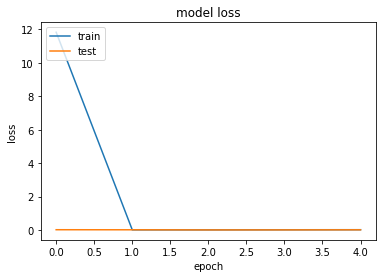

In [106]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

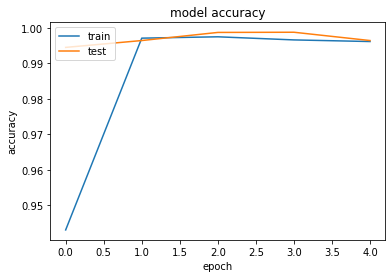

In [107]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Prediction

In [84]:
classes = ['P', 'K', 'Q', 'B', 'N', 'R', 'p', 'k', 'q', 'b', 'n', 'r', 'Empty']

In [109]:
im = cv2.imread('dataset/samples/03.jpeg')
im = np.expand_dims(im, axis=0)

def get_pred(im):
    prediction = model.predict(im)
    prediction = prediction[0].tolist()
    max_pred = max(prediction)
    max_index = prediction.index(max_pred)
    pred = classes[max_index]
    print(prediction)
    return pred

pred = get_pred(im)
print("Predicted label is: " + pred)

2022-08-05 18:48:51.770598: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 871ms/step
[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.6489351766216183e-29, 0.0, 0.0, 0.0]
Predicted label is: B


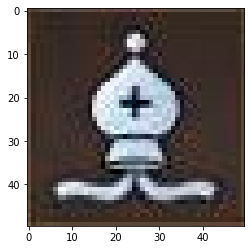

In [86]:
im = cv2.imread('dataset/samples/03.jpeg')
plt.imshow(im)

### Create function to combine everything

In [87]:
path = 'rRN2N2-5N2-Kp4N1-8-8-5nnN-2r2b1k-6r1.jpeg'
im_path = 'dataset/train/' + path

'rRN2-7-2p4---22nN-221-6'
'rRN22-52-Kp41-8-8-5nN-221-61'
'rRN2N2-5N2-Kp4N1-8-8-5nnN-2r2b1k-6r1'

def get_board_labeled(im_path):
    im = cv2.imread(im_path)
    label = ''
    preds = []
    empty = 0
    flag = 0
    for i in range(8):
        for j in range(8):
            cropped_im = im[0+50*i:50+50*i, 0+50*j:50+50*j]
            cropped_im = cropped_im.astype('float32')
            cropped_im = np.expand_dims(cropped_im, axis=0)
            new_pred = get_pred(cropped_im)      
            
            if new_pred == 'Empty':
                flag = 1
                empty += 1
                new_pred = ''
                       
            else:
                flag = 0
                
            if (empty > 0 and flag == 0) or (empty > 0 and j == 7):
                label += str(empty)
                label += new_pred
                empty = 0

            else:
                label += new_pred

        label = label + '-'
        
    return label[0:-1]
                

### Test on an image

In [110]:
path = '1b1KN3-7B-2R5-4kr1r-1Q6-2Q1pr2-2B5-4n3.jpeg'
im_path = 'dataset/test/' + path
get_board_labeled(im_path)

2022-08-05 18:51:55.214029: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 455ms/step
[3.3418089060432976e-06, 1.0080505489895586e-05, 4.666255648544393e-08, 7.910330737104232e-07, 2.894082172133494e-06, 2.476515192029183e-06, 7.471469842812439e-08, 1.1397857946349177e-07, 1.9283525887203723e-09, 5.1171927140103435e-08, 1.1757331463968512e-07, 7.350304542796948e-08, 0.9999799728393555]
1/1 [==============================] - 0s 30ms/step
[2.6523367988137876e-14, 2.859478604420873e-13, 2.492583458065747e-18, 4.036429610693171e-12, 1.3102013918242505e-10, 4.469405748275257e-12, 1.2990435038773285e-07, 2.444982669658202e-07, 7.213070585265768e-09, 0.999998927116394, 4.693052630955208e-07, 2.2638171515154681e-07, 1.4761615541036832e-10]
1/1 [==============================] - 0s 10ms/step
[2.6968677957484033e-06, 7.497269507439341e-06, 4.6668937159211055e-08, 7.492127451769193e-07, 2.8332156034593936e-06, 2.3995326046133414e-06, 1.0457430477117668e-07, 1.3344801175207976e-07, 2.6658784069155672e-09, 6.873981561739129e-08, 1

1/1 [==============================] - 0s 15ms/step
[2.5177079805871472e-05, 8.26532268547453e-05, 6.095010007811652e-07, 2.362465238547884e-05, 3.922752512153238e-05, 5.846617932547815e-05, 0.0004456658789422363, 0.00010087262489832938, 1.694559796305839e-05, 0.000330861919792369, 0.00022128944692667574, 0.00021963725157547742, 0.998434841632843]
1/1 [==============================] - 0s 10ms/step
[1.6460026017739438e-06, 5.488574515766231e-06, 2.6722728918571192e-08, 5.435132948150567e-07, 1.7045998674802831e-06, 1.6693887801011442e-06, 5.409798475852767e-08, 8.102264814624505e-08, 1.041612240904044e-09, 3.819417671024894e-08, 7.47786970123343e-08, 4.890477711683161e-08, 0.9999886751174927]
1/1 [==============================] - 0s 11ms/step
[1.3932403817307204e-06, 2.7446390049590264e-06, 1.8769190646139577e-08, 1.462406885366363e-06, 2.877438646464725e-06, 3.969710178353125e-06, 0.00045423212577588856, 0.0001406418887199834, 2.1778747395728715e-05, 0.00010862563794944435, 0.0001266

1/1 [==============================] - 0s 9ms/step
[9.655490202931105e-07, 1.7152445934698335e-06, 8.972196319234627e-09, 6.954990681151685e-07, 2.0525872059806716e-06, 2.508608986317995e-06, 0.0007044397061690688, 0.00014828730490989983, 2.7957599741057493e-05, 0.0001470449788030237, 0.00013527224655263126, 0.0001711812219582498, 0.9986578226089478]
1/1 [==============================] - 0s 9ms/step
[6.34526678704346e-14, 7.57344013890826e-12, 5.253847487271535e-13, 1.0, 2.634353116070598e-19, 1.6567901375772407e-18, 9.857997140296689e-32, 6.227062103903612e-28, 3.758835192159514e-25, 1.949008988054446e-13, 1.7287461492586753e-25, 1.3753457727911032e-20, 7.339496967176886e-32]
1/1 [==============================] - 0s 8ms/step
[9.942385759131867e-07, 1.5867152569626342e-06, 9.929380873074933e-09, 8.741952228774608e-07, 2.5559572804922936e-06, 3.3790092857088894e-06, 0.00042455701623111963, 0.00015189666009973735, 3.325457510072738e-05, 0.0001551530003780499, 0.00011639948206720874, 0.

'1b1KN3-7B-2R5-4kr1r-1Q6-2Q1pr2-2B5-4n3'

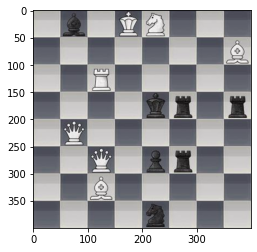

In [95]:
im = cv2.imread(im_path)
plt.imshow(im)

# Performance

In [130]:
y_pred = model.predict(X_test)

342/342 [==============================] - 3s 7ms/step


In [120]:
len(y_pred)

10939

In [121]:
len(y_test)

10939

In [131]:
from sklearn.metrics import confusion_matrix,f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[ 941    0    0    0    0    0    0    0    0    0    0    0    0]
 [   0 1001    3    0    0    0    0    0    0    0    0    0    0]
 [   0    0  449    0    0    0    0    0    0    0    0    0    0]
 [   0    0    1  846    0    0    0    0    0    4    0    0    0]
 [   0    0    0    0  830    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0  887    0    0    0    0    0    1    0]
 [   0    0    0    0    0    0  908    0    0    0    0    1    2]
 [   0    0    0    0    0    0    0 1069    0    0    0    0    0]
 [   0    0    2    0    0    0    0    0  465    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0  907    0    0    0]
 [   0    0    0    0    0    0    0    1    0    1  886    2    0]
 [   0    0    0    0    0    0    0    0    0    0    0  887    1]
 [   0    0    0    0    0    0    0    0    0    0    0    0  844]]


In [136]:
print("Precison:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))
print("Accuracy:", accuracy_score(y_test, y_pred))

Precison: 0.9982751221766735
Recall: 0.9982630953469238
F1 Score: 0.9982644554193204
Accuracy: 0.9982630953469238


### Save model

In [143]:
joblib.dump(model, 'model3.joblib', compress=3)

INFO:tensorflow:Assets written to: ram://1997fc19-c260-463f-b748-d392bd5d6c6d/assets


INFO:tensorflow:Assets written to: ram://1997fc19-c260-463f-b748-d392bd5d6c6d/assets


['model3.joblib']